<h1 align='center'>Deteccion de anomalías en grandes volúmenes de datos</h1>


## Análisis del dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab

In [4]:
df = pd.read_csv('creditcard.csv')

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Ahora determinamos la cantidad de transacciones fraudulentas en el dataset.

In [6]:
frauds = (df['Class'] == 1)

In [7]:
len(df[frauds])

492

In [8]:
len(df)

284807

Lo anterior nos indica que de las $284,807$ transacciones en el dataset, $492$ corresponden a transacciones fraudulentas, de modo que el resto de transacciones, $284,315$, son transacciones normales. Podemos visualizar esto en un gráfico de pastel.

<AxesSubplot:>

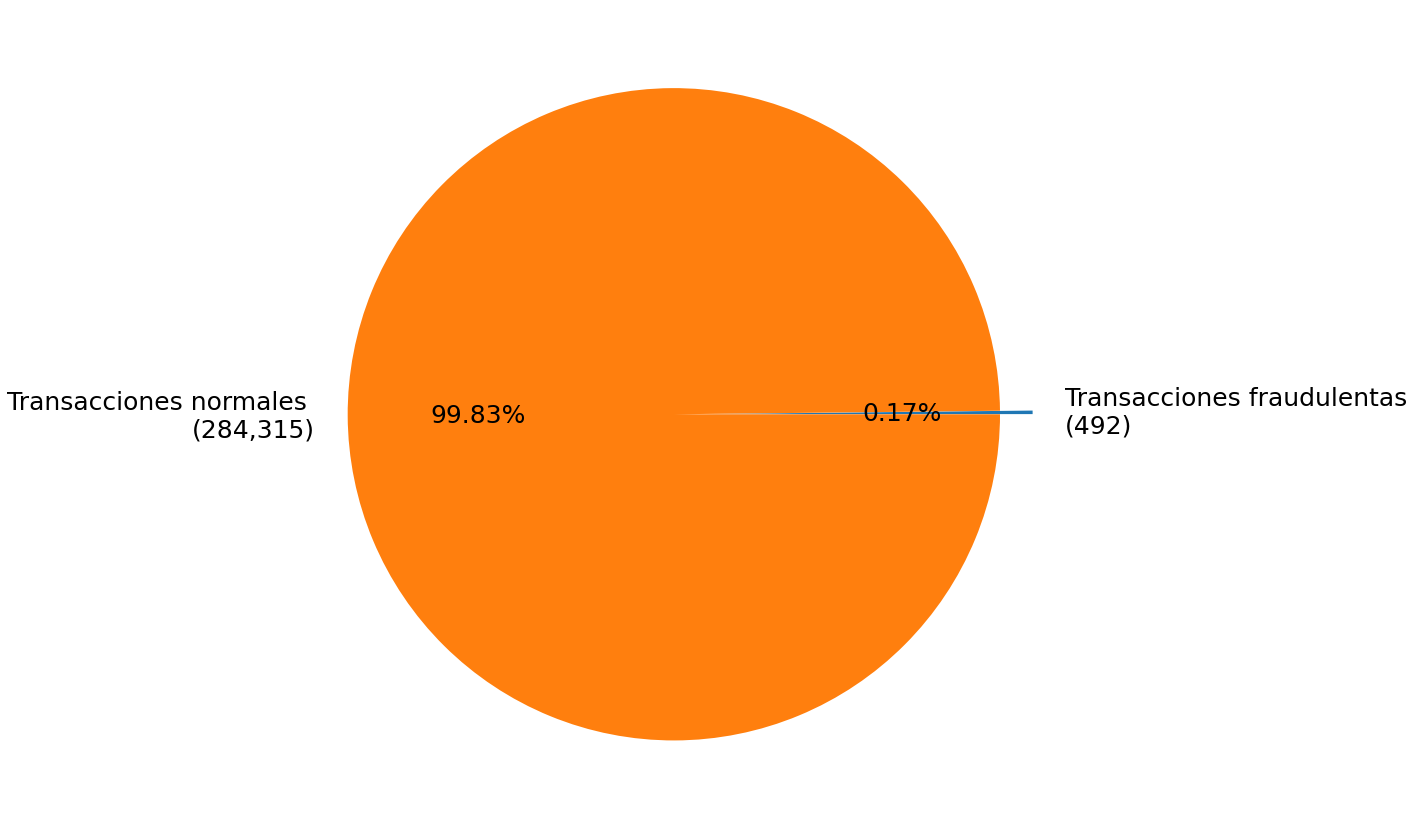

In [9]:
plot_data = pd.DataFrame({ 'Tipo de transacción': ['Transacciones fraudulentas \n(492)', 'Transacciones normales \n(284,315)'],
                  'Cantidad': [492, 284315]})

plot_data.set_index('Tipo de transacción', inplace=True)
plot = plot_data.plot.pie(y='Cantidad', legend=False, \
                   autopct='%1.2f%%', explode=(0, 0.1), \
                   shadow=False, startangle=0, figsize=(15, 15), fontsize=25);
pylab.ylabel('')
plot

Podemos verificar que en este dataset no hay datos nulos:

In [10]:
df.isnull().values.any()

False

In [11]:
df.isnull().sum().sum()

0

## Matriz de correlación

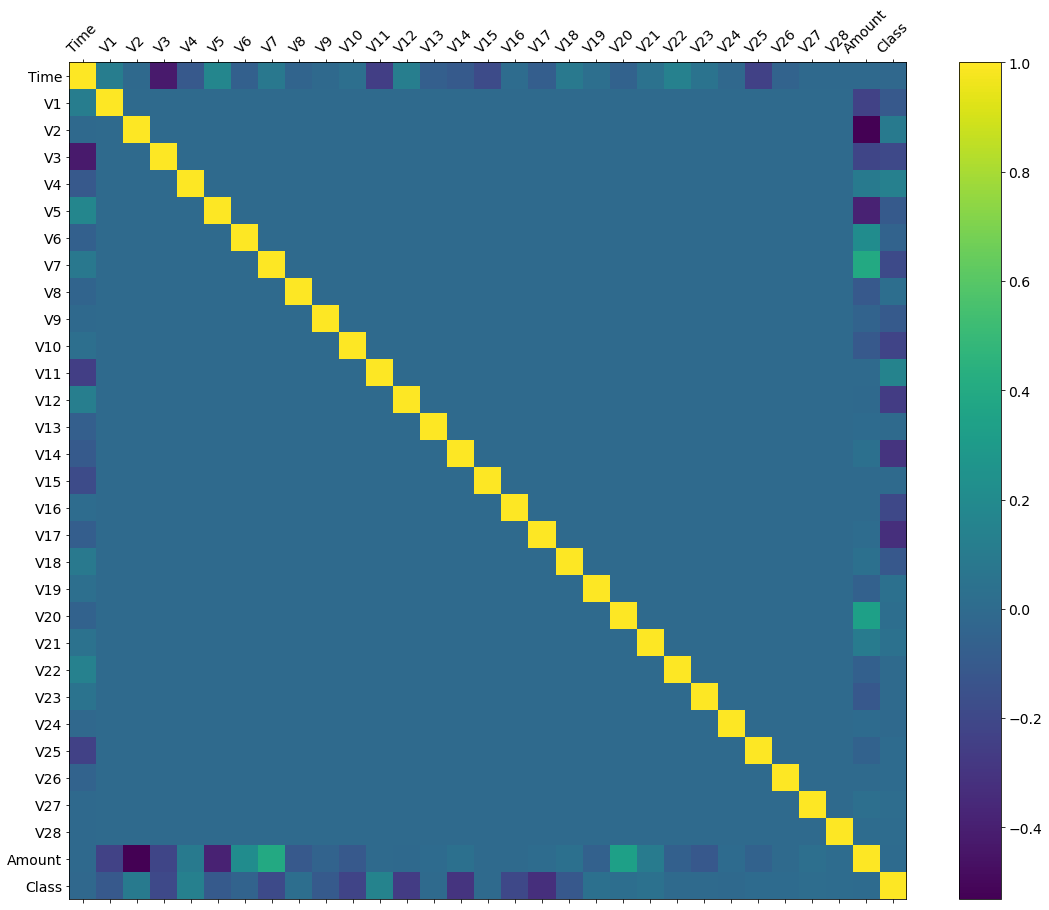

In [12]:
f = plt.figure(figsize=(19, 15))
corrMatrix = df.corr()
plt.matshow(corrMatrix, fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

## Implementando random undersampling

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)


In [14]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [15]:

df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
178080,-0.038706,0.455539,-0.710656,0.747647,0.550059,-0.061652,2.537722,4.642815,0.019343,1.256290,...,0.241120,-0.561891,-1.413091,-0.103222,0.628737,0.434080,-0.762822,0.372841,0.136757,0
95534,0.138476,-0.227141,1.193916,-0.571085,0.742522,-0.014588,-0.624561,0.832162,-0.833350,0.272897,...,0.062908,-0.049502,0.207265,-0.265272,-0.679294,0.511812,1.246604,-0.028671,-0.006112,1
161302,-0.139733,0.345199,-1.361791,0.275785,0.201625,1.169658,1.445640,-0.184183,0.244378,-0.962341,...,-0.736502,0.887172,0.834114,0.023231,0.658687,0.114490,-0.272377,0.229463,0.116467,0
154286,-0.294557,0.192190,-1.465316,-1.093377,-0.059768,1.064785,11.095089,-5.430971,-9.378025,-0.446456,...,-1.457610,1.160623,-1.259697,-15.981649,-0.883670,-3.536716,-0.592965,0.675525,0.424849,1
40085,-0.293440,-0.524043,1.083693,1.179501,-1.346150,1.998824,0.818034,-0.771419,0.230307,0.093683,...,-0.060159,-0.312000,-0.639700,-0.120249,-0.180218,0.609283,-0.339524,0.096701,0.114972,1


<AxesSubplot:>

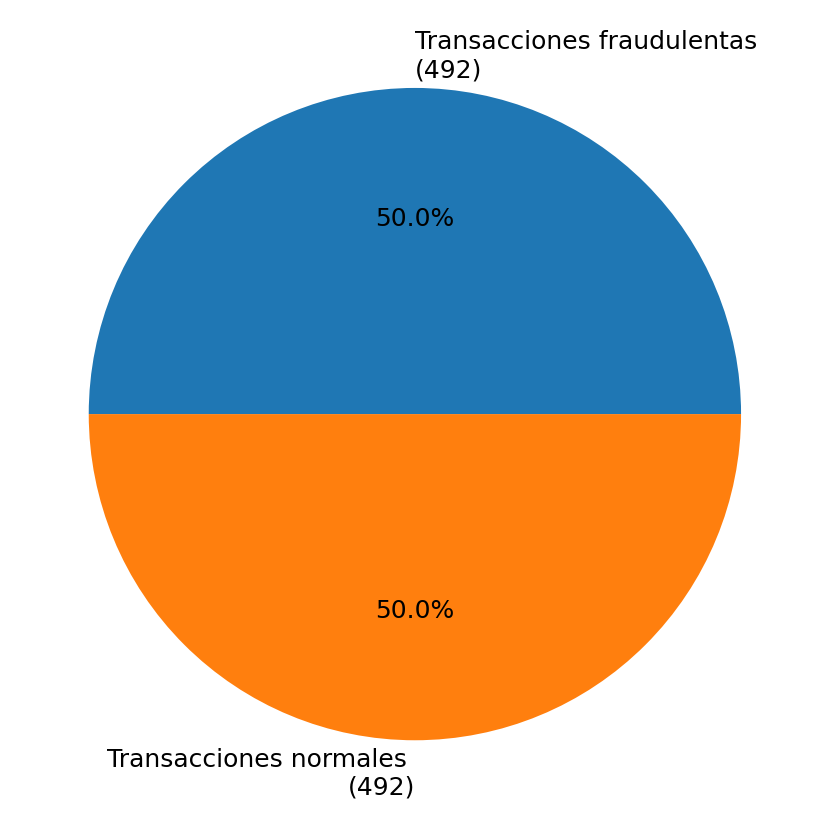

In [16]:
plot_data = pd.DataFrame({ 'Tipo de transacción': ['Transacciones fraudulentas \n(492)', 'Transacciones normales \n(492)'],
                  'Cantidad': [492, 492]})

plot_data.set_index('Tipo de transacción', inplace=True)
plot = plot_data.plot.pie(y='Cantidad', legend=False, \
                   autopct='%1.1f%%', \
                   shadow=False, startangle=0, figsize=(15, 15), fontsize=25);
pylab.ylabel('')
plot

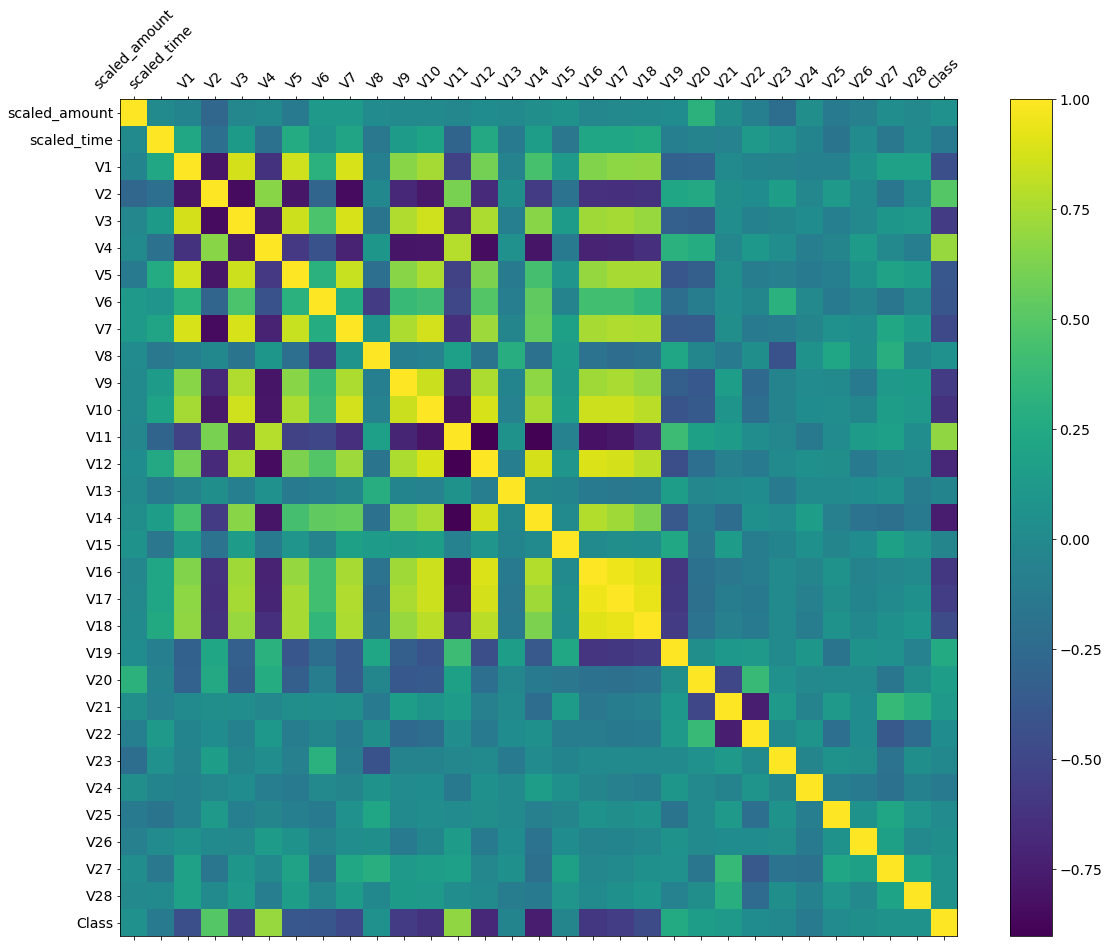

In [17]:
f = plt.figure(figsize=(19, 15))
corrMatrix = new_df.corr()
plt.matshow(corrMatrix, fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

## Entrenando modelos de clasificación

### K nearest neighbor classifier

In [18]:
# Undersampling before cross validating
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [20]:
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

classifier = KNeighborsClassifier()

classifier.fit(X_train, y_train)

training_score = cross_val_score(classifier, X_train, y_train, cv=5)

print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  KNeighborsClassifier Has a training score of 94.0 % accuracy score


## Decision tree classifier

In [26]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()

classifier.fit(X_train, y_train)

training_score = cross_val_score(classifier,X_train, y_train, cv=5)

print(classifier.__class__.__name__,"has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

DecisionTreeClassifier has a training score of 91.0 % accuracy score


## SVM Classifier

In [23]:
from sklearn.svm import SVC
classifier = SVC()

classifier.fit(X_train, y_train)

training_score = cross_val_score(classifier,X_train, y_train, cv=5)

print(classifier.__class__.__name__,"has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

SVC has a training score of 94.0 % accuracy score


## Logistic Regression Classifier

In [25]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

classifier.fit(X_train, y_train)

training_score = cross_val_score(classifier,X_train, y_train, cv=5)

print(classifier.__class__.__name__,"has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

LogisticRegression has a training score of 95.0 % accuracy score
